# Importe as bibliotecas necessárias

In [1]:
# Instalando as bibliotecas necessárias
# %pip install -U pip setuptools wheel
# %pip install pymongo
# %pip install pandas
# %pip install nltk
# %pip install wordcloud
# %pip install spacy
# %pip install matplotlib
# %pip install numpy==1.26.4
# %pip install -U scikit-learn
# %pip install unidecode

# Importando as bibliotecas

In [2]:
import pandas as pd
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
from datetime import datetime
from db import connection_db as conndb
from db import filters
from utils import plot_graphs
from utils.text_treatment import TextTreatment
from utils.text_vectorization import TextVectorization
from dateutil.relativedelta import relativedelta
from utils.nuvem_palavras import NuvemPalavras
from tqdm.auto import tqdm

tqdm.pandas()
from utils.busca_palavras import BuscaPalavras

In [3]:
mongo_connection = conndb.MongoDBConnection(uri='mongodb://localhost:27017/', database_name='dadosVivamente',
                                            collection_name='dadosSemFiltros')
mongo_connection.connect()
collection = mongo_connection.collection

Conexão estabelecida com sucesso ao banco de dados.


In [4]:
collection_filters = filters.CollectionFilters(collection)
collection_filters.apply_pipeline1('dadosComFiltrosIniciais')
collection_filters.apply_pipeline2(7, 2, 'posts7anos2anos')
collection_filters.apply_pipeline3('postsComBDIAndInfos')
collection_filters.apply_pipeline4('postsComBDIAndInfosFiltroDataPosts')
data_inicio = datetime(2017, 12, 1)
data_fim = data_inicio - relativedelta(months=6)
collection_filters.apply_pipeline5('postsFiltradosPorData', data_inicio, data_fim)
collection = collection_filters.collection

INFO:root:A coleção já existe: dadosComFiltrosIniciais
INFO:root:A coleção já existe: posts7anos2anos
INFO:root:A coleção já existe: postsComBDIAndInfos
INFO:root:A coleção já existe: postsComBDIAndInfosFiltroDataPosts
INFO:root:A coleção já existe: postsFiltradosPorData


In [5]:
print(collection_filters.quant_users_cat('nivel', '$eq', 2),
      collection_filters.count_users_by_gender('nivel', '$eq', 2, 'M'),
      collection_filters.count_users_by_gender('nivel', '$eq', 2, 'F'))

144 21 123


In [6]:
# Filtrando documentos com o atributo maior que 3
filtro = {"nivel": {"$eq": 2}}
documentos = collection.find(filtro)

In [7]:
# Transformando os documentos em um DataFrame
df = pd.DataFrame(list(documentos))
df.head()

,_id,idade,sexo,id_usuario,nivel,pessimismo,tristeza,fracasso,prazer,culpa,...,quantAmigos,postMessage,postStory,postCreated_time,diaDaSemana,hora,minutos,diaDoMes,mes,ano
0,59c325925fef19001e03ae70,33,F,1358116567556711,2.0,1,1,0,0,1,...,1099,❤❤❤,Elisa Lacal shared a memory.,2017-09-20 13:43:35,Quarta-feira,13,43,20,9,2017
1,59c325925fef19001e03ae71,33,F,1358116567556711,2.0,1,1,0,0,1,...,1099,NaN,Elisa Lacal shared Colégio Master :: Oficial :...,2017-09-16 10:23:09,Sábado,10,23,16,9,2017
2,59c325925fef19001e03ae72,33,F,1358116567556711,2.0,1,1,0,0,1,...,1099,NaN,Ellen Bueno added 4 new photos — with Marcus A...,2017-09-10 22:09:50,Domingo,22,9,10,9,2017
3,59c325925fef19001e03ae73,33,F,1358116567556711,2.0,1,1,0,0,1,...,1099,#pescadores_br #caceres #riosepotuba #fishing,Murilo Alves Gonçalves Dos Santos is with Marc...,2017-09-10 20:05:32,Domingo,20,5,10,9,2017
4,59c325925fef19001e03ae74,33,F,1358116567556711,2.0,1,1,0,0,1,...,1099,Parabéns Giulia!! O tão esperado #DiaDaAlta ch...,REDEORTO Várzea Grande is feeling blissful wit...,2017-09-05 20:05:46,Terça-feira,20,5,5,9,2017


In [8]:
print(df.dtypes)
# Lista de colunas que precisam ser convertidas
colunas_para_converter = [
    'pessimismo', 'tristeza', 'fracasso', 'prazer', 'culpa', 'punicao', 'estima',
    'critica', 'suicida', 'choro', 'agitacao', 'interesse', 'indecisao',
    'desvalorizacao', 'energia', 'sono', 'irritabilidade', 'apetite',
    'concentracao', 'fadiga', 'int_sexo', 'quantAmigos'
]

df[colunas_para_converter] = df[colunas_para_converter].astype('int64')

_id                         object
idade                        int64
sexo                        object
id_usuario                  object
nivel                      float64
pessimismo                  object
tristeza                    object
fracasso                    object
prazer                      object
culpa                       object
punicao                     object
estima                      object
critica                     object
suicida                     object
choro                       object
agitacao                    object
interesse                   object
indecisao                   object
desvalorizacao              object
energia                     object
sono                        object
irritabilidade              object
apetite                     object
concentracao                object
fadiga                      object
int_sexo                    object
quantAmigos                 object
postMessage                 object
postStory           

In [9]:
# Salvar o DataFrame em um arquivo CSV
df.to_csv('dados/com_filtros_datas/6meses/so_suicida_6_meses.csv', index=False)

In [10]:
# Agrupar por usuário, mês e ano
posts_grouped = df.groupby(['id_usuario', 'mes', 'ano']).size().reset_index(name='quantidade')

# Adicionar coluna com o período e converter para datetime
posts_grouped['periodo'] = pd.to_datetime(posts_grouped['mes'].astype(str) + '/' + posts_grouped['ano'].astype(str),
                                          format='%m/%Y')

# Deve retornar 0 se a conversão foi bem-sucedida.
print(posts_grouped['periodo'].isnull().sum())

posts_grouped.dtypes

0


id_usuario            object
mes                    int64
ano                    int64
quantidade             int64
periodo       datetime64[ns]
dtype: object

# Plotar quantidade de posts por usuário

In [11]:
# plot_graphs.PlotGraphs().plot_posts_per_user(posts_grouped, 'dados/com_filtros_datas/6meses/graficos')

# Efentuando a limpeza dos dados

In [12]:
tratamento_texto = TextTreatment()

/home/paulovss/Documentos/projects/python/analise_dados/venv/lib/python3.12/site-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

In [13]:
df['postMessageLimpo'] = df['postMessage'].fillna('').progress_apply(
    lambda texto: tratamento_texto.preprocessamento_texto(texto) if texto else '')

  0%|          | 0/34514 [00:00<?, ?it/s]

In [14]:
busca_palavras = BuscaPalavras()

In [15]:
resultado = busca_palavras.string_matching(df['postMessageLimpo'], 'dados/datasets/termos_depressivos_pt_br.txt')
# Salvar o resultado em um arquivo CSV
resultado.to_csv('dados/com_filtros_datas/6meses/so_suicida_termos_depressivos.csv')

resultados_fuzzy = busca_palavras.fuzzy_string_matching(df['postMessageLimpo'],
                                                        'dados/datasets/termos_depressivos_pt_br.txt')
df_resultados_fuzzy = pd.DataFrame(resultados_fuzzy,
                                   columns=['Palavra Procurada', 'Palavra Encontrada', 'Similaridade'])
# Salvar o resultado em um arquivo CSV
df_resultados_fuzzy.to_csv('dados/com_filtros_datas/6meses/so_suicida_termos_depressivos_fuzzy.csv', index=False)

In [16]:
# Exibir apenas as colunas postMessage e postMessageLimpo
df[['postMessage', 'postMessageLimpo']].head()

,postMessage,postMessageLimpo
0,❤❤❤,
1,NaN,
2,NaN,
3,#pescadores_br #caceres #riosepotuba #fishing,pescador cacer riosepotuba fishing
4,Parabéns Giulia!! O tão esperado #DiaDaAlta ch...,esperar diadaalta chegar unidade varzea famili...


In [17]:
# Carregar stopwords para o TF-IDF e o Bag of Words
stop_words = tratamento_texto.get_stopwords()

In [18]:
text_vectorizer = TextVectorization(df, stop_words)
# Vetorização TF-IDF
resultados_tfidf = text_vectorizer.tfidf_vectorization(
    'dados/com_filtros_datas/6meses/so_suicida_resultados_tfidf_unigramas.csv', 0.60, 2,
    (1, 1))

# Vetorização Bag of Words
resultados_bow = text_vectorizer.bag_of_words_vectorization(
    'dados/com_filtros_datas/6meses/so_suicida_resultados_bow_unigramas.csv',
    0.85, 5, (1, 1))

            id_usuario     palavra     score
0     1358116567556711  vivasorrir  0.038563
1     1358116567556711    familiar  0.030189
2     1358116567556711      varzea  0.024439
3     1358116567556711   agradecer  0.022785
4     1358116567556711     sorriso  0.021282
...                ...         ...       ...
1435   336339230103012        dade  0.009901
1436   336339230103012        amoo  0.009901
1437   336339230103012    entender  0.009901
1438   336339230103012       ferio  0.008163
1439   336339230103012     lembrar  0.007485

[1440 rows x 3 columns]
            id_usuario     palavra  contagem
0     1358116567556711    familiar        13
1     1358116567556711        vida        10
2     1358116567556711        deus         9
3     1358116567556711   agradecer         8
4     1358116567556711  vivasorrir         8
...                ...         ...       ...
1435   336339230103012     comente         1
1436   336339230103012      chegar         1
1437   336339230103012     lem

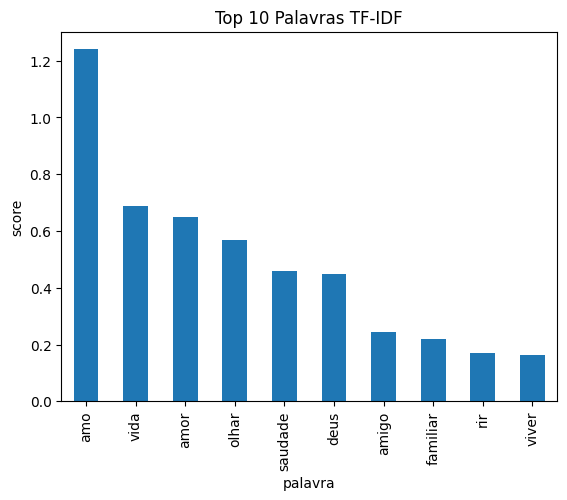

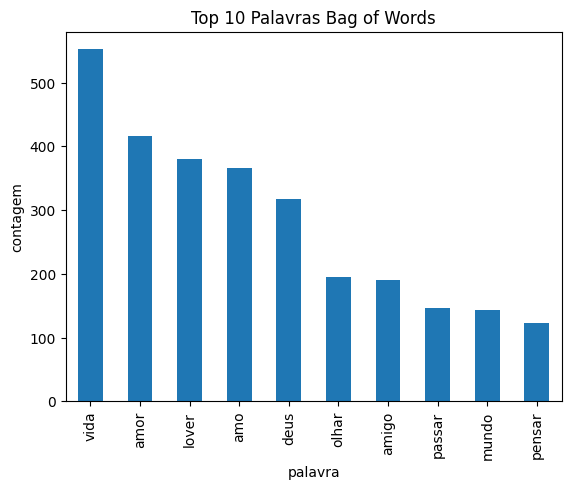

In [19]:
text_vectorizer.plot_top_words(resultados_tfidf, column='score', title='Top 10 Palavras TF-IDF')
text_vectorizer.plot_top_words(resultados_bow, column='contagem', title='Top 10 Palavras Bag of Words')

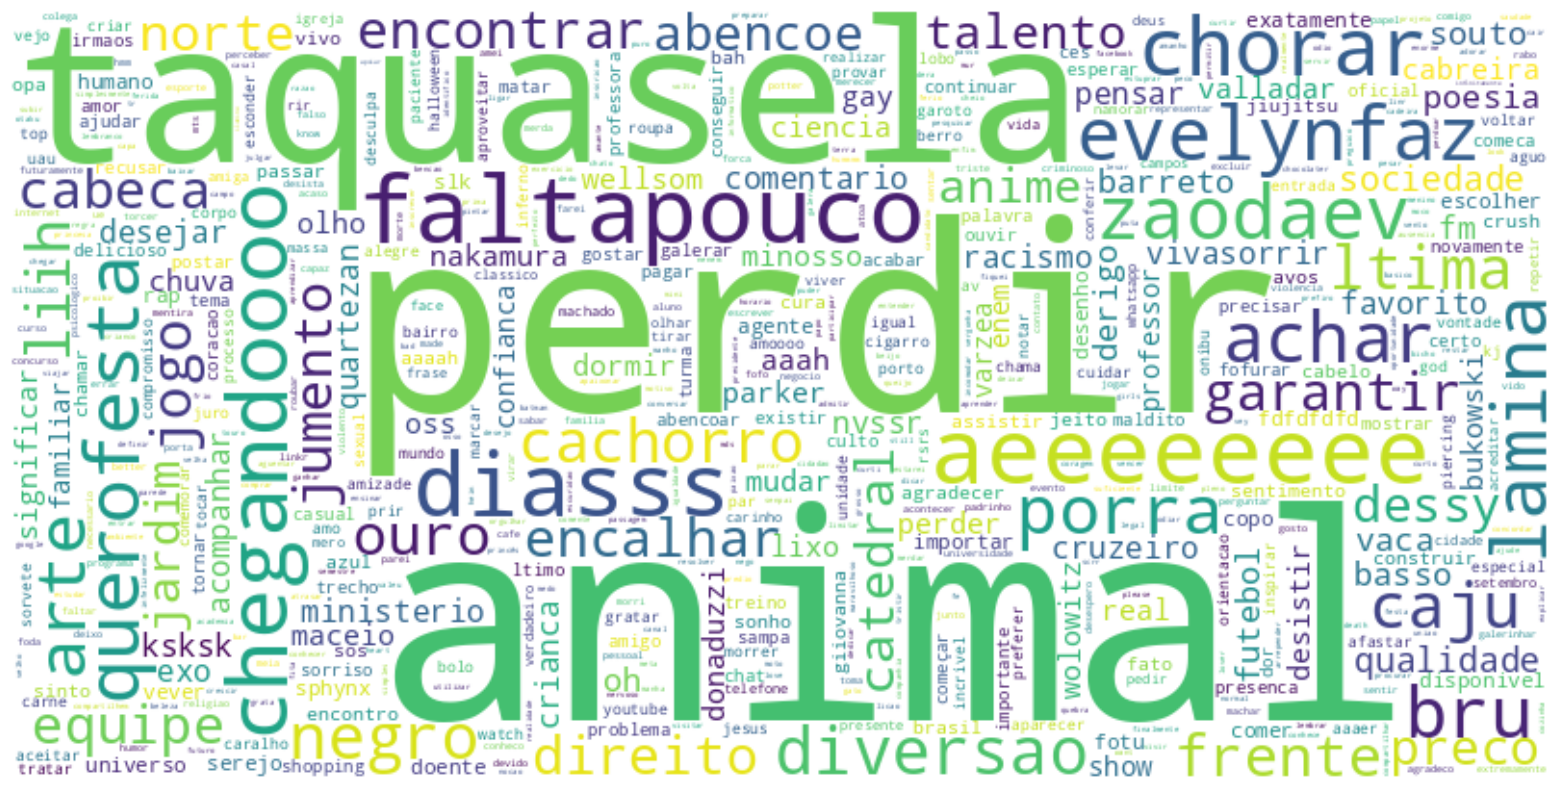

In [20]:
frequencias_bow = dict(zip(resultados_bow['palavra'], resultados_bow['contagem']))

# Gerar e plotar a nuvem de palavras
NuvemPalavras.plot_nuvem_palavras(frequencias_bow)

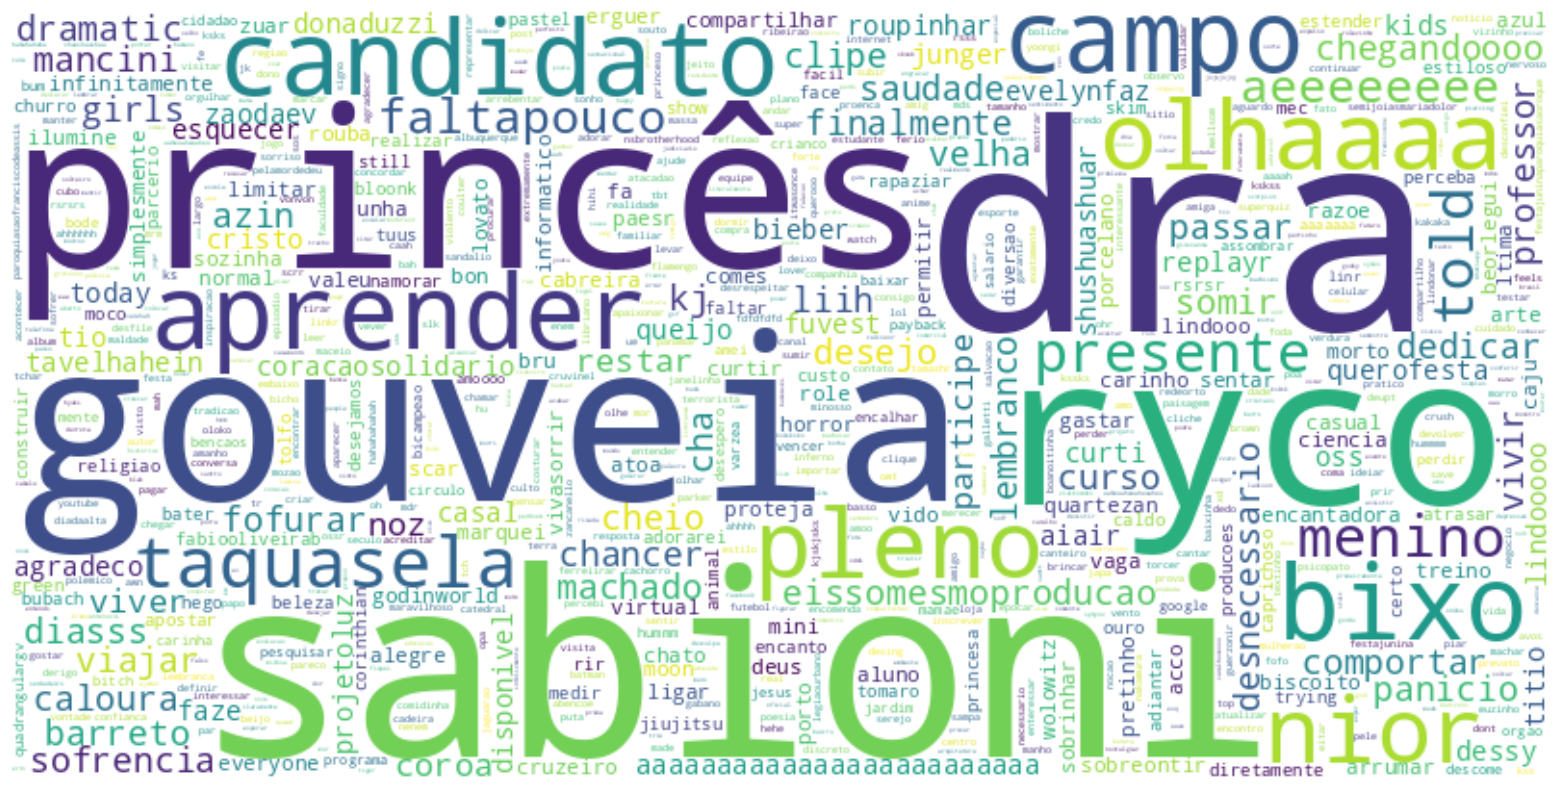

In [21]:
frequencias_tfidf = dict(zip(resultados_tfidf['palavra'], resultados_tfidf['score']))

# Gerar e plotar a nuvem de palavras
NuvemPalavras.plot_nuvem_palavras(frequencias_tfidf)